In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, cohen_kappa_score
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import RandomOverSampler

In [2]:
# Dataset from https://www.kaggle.com/jessemostipak/hotel-booking-demand

df = pd.read_csv('./Data/hotel_bookings.csv')

In [3]:
df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [5]:
# Converting string values into ints

In [6]:
# Converting hotel types from str to int

df.hotel = df.hotel.map({'City Hotel':0, 'Resort Hotel':1})
df.hotel.unique()

array([1, 0], dtype=int64)

In [7]:
# Converting month from str to int

df.arrival_date_month = df.arrival_date_month.map({'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September': 9, 'October':10, 'November':11, 'December':12})

In [8]:
# Creating a timeseries date and extraction of weekdays

df['date'] = pd.to_datetime(df['arrival_date_year'].map(str) + '-' + df['arrival_date_month'].map(str) + '-' + df['arrival_date_day_of_month'].map(str))

In [9]:
df['weekday'] = df['date'].dt.weekday

In [10]:
df.meal.unique()

array(['BB', 'FB', 'HB', 'SC', 'Undefined'], dtype=object)

In [11]:
# Converting meal from str to int
df.meal = df.meal.map({'Undefined':0, 'BB':1, 'HB':2, 'FB':3, 'SC':4})

df.meal.unique()

array([1, 3, 2, 4, 0], dtype=int64)

In [12]:
# Converting country from str to int using LabelEncoder

df.country.fillna(df.country.mode().to_string(), inplace=True)    # Filling Null values with the most common value in the dataset - here PRT for Portugal
le = LabelEncoder()
df.country = le.fit_transform(df.country)
df.country.unique()

array([136,  60, 170,  52,  77,  57,   0, 140, 125, 128,   7, 134,  44,
        16,  30,  35,  67,  82, 124,  47, 141, 155,  12,  53,  43,  26,
        55, 114,  28, 101, 154,   4,  76,  32, 108, 104, 167, 149, 102,
       135, 150,  31,  13,  24, 100, 163, 175,   2,  81,  41, 176,  38,
       177,  49,  92,  39,  73,   6, 162,  83,  72,  70,  78,  61,   5,
        64, 169,  84,  29,  42,  36,  62,  93, 122, 107, 172, 153,  56,
        87, 129,  74,  95, 132, 145, 156,  14,  21, 127, 159,  48, 109,
       118,   8,  86,  99,  40,  34,  23, 116,  37, 152, 166,  20,  33,
        85, 157, 146,  15, 143, 174, 133, 139,  51, 131, 111, 117,  50,
       106,  80, 171, 126,  22, 103, 158, 164,  45, 151,  91,  54,  79,
        71, 142,  89, 105,  19,  75, 160, 123,  17, 173, 165,  59,  63,
       161,  65,  88,  98,  66, 113, 168, 119,  58, 112, 130,  18,  96,
       110, 120,  25, 137,  27,   1,   3, 148,  46, 138,  69,  97,  10,
        68,   9, 115, 121,  90, 144,  11, 147,  94])

In [13]:
df.market_segment.unique()

array(['Direct', 'Corporate', 'Online TA', 'Offline TA/TO',
       'Complementary', 'Groups', 'Undefined', 'Aviation'], dtype=object)

In [14]:
# Converting market_segment from str to int

le = LabelEncoder()
df['market_segment'] = le.fit_transform(df['market_segment'])
df.market_segment.unique()

array([3, 2, 6, 5, 1, 4, 7, 0])

In [15]:
df.distribution_channel.unique()

array(['Direct', 'Corporate', 'TA/TO', 'Undefined', 'GDS'], dtype=object)

In [16]:
# Converting distribution_channel from str to int

df.distribution_channel = df.distribution_channel.map({'Undefined':0, 'Direct':1, 'Corporate':2, 'TA/TO':3, 'GDS':4})
df.distribution_channel.unique()

array([1, 2, 3, 0, 4], dtype=int64)

In [17]:
df.reserved_room_type.unique()

array(['C', 'A', 'D', 'E', 'G', 'F', 'H', 'L', 'P', 'B'], dtype=object)

In [18]:
df.assigned_room_type.unique()

array(['C', 'A', 'D', 'E', 'G', 'F', 'I', 'B', 'H', 'P', 'L', 'K'],
      dtype=object)

In [19]:
# Creating a new feature: room. 
# If a guest does not get the reserved room it might raise the probability that she cancels the reservation.

df['room'] = 0
df.loc[df.reserved_room_type == df.assigned_room_type , 'room'] = 1

In [20]:
# Converting reserved_room_type from str to int

le = LabelEncoder()
df['reserved_room_type'] = le.fit_transform(df['reserved_room_type'])
df.reserved_room_type.unique()

array([2, 0, 3, 4, 6, 5, 7, 8, 9, 1])

In [21]:
# Converting assigned_room_type from str to int

le = LabelEncoder()
df['assigned_room_type'] = le.fit_transform(df['assigned_room_type'])
df.assigned_room_type.unique()

array([ 2,  0,  3,  4,  6,  5,  8,  1,  7, 11, 10,  9])

In [22]:
# Creating a new column: net_cancelled. It contains 1 if the guest has cancelled more bookings in the past than the number of booking she did not cancel, otherwise 0

df['net_cancelled'] = 0
df.loc[ df.previous_cancellations > df.previous_bookings_not_canceled, 'net_cancelled'] = 1


In [23]:
df.deposit_type.unique()

array(['No Deposit', 'Refundable', 'Non Refund'], dtype=object)

In [24]:
# Converting deposit_type from str to int

df.deposit_type = df.deposit_type.map({'No Deposit':0, 'Refundable':1, 'Non Refund':2})
df.deposit_type.unique()

array([0, 1, 2], dtype=int64)

In [25]:
df.customer_type.unique()

array(['Transient', 'Contract', 'Transient-Party', 'Group'], dtype=object)

In [26]:
# Converting customer_type from str to int

df.customer_type = df.customer_type.map({'Transient':1, 'Transient-Party':2, 'Contract':3, 'Group':4})
df.customer_type.unique()

array([1, 3, 2, 4], dtype=int64)

In [27]:
df.reservation_status.unique()

array(['Check-Out', 'Canceled', 'No-Show'], dtype=object)

In [28]:
# Converting reservation_status from str to int

df.reservation_status = df.reservation_status.map({'No-Show':0, 'Check-Out':1, 'Canceled':2})
df.reservation_status.unique()

array([1, 2, 0], dtype=int64)

In [29]:
df.required_car_parking_spaces.unique()

array([0, 1, 2, 8, 3], dtype=int64)

In [30]:
df.shape

(119390, 36)

<AxesSubplot:>

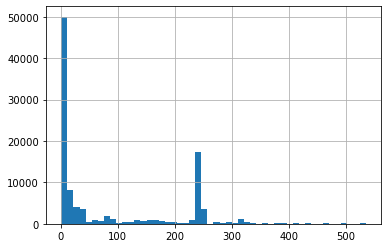

In [31]:
df.agent.hist(bins = 50)


In [32]:
df['company'].mean()

189.26673532440782

In [33]:
# Filling missing values in children with the mean
df.children.fillna(round(df.children.mean()), inplace = True)

# Filling missing values with mode
df['agent'] = df['agent'].fillna(df['agent'].mean())
df['company'] = df['company'].fillna(df['company'].mean())

# Converting unneccessary float types into int types
df[['children', 'company', 'agent']] = df[['children', 'company', 'agent']].astype('int64')

In [34]:
# Adults, babies and children cant be 0 at same time, so these 180 rows need to be dropped

df = df.drop(df[(df.adults+df.babies+df.children)==0].index)

<AxesSubplot:>

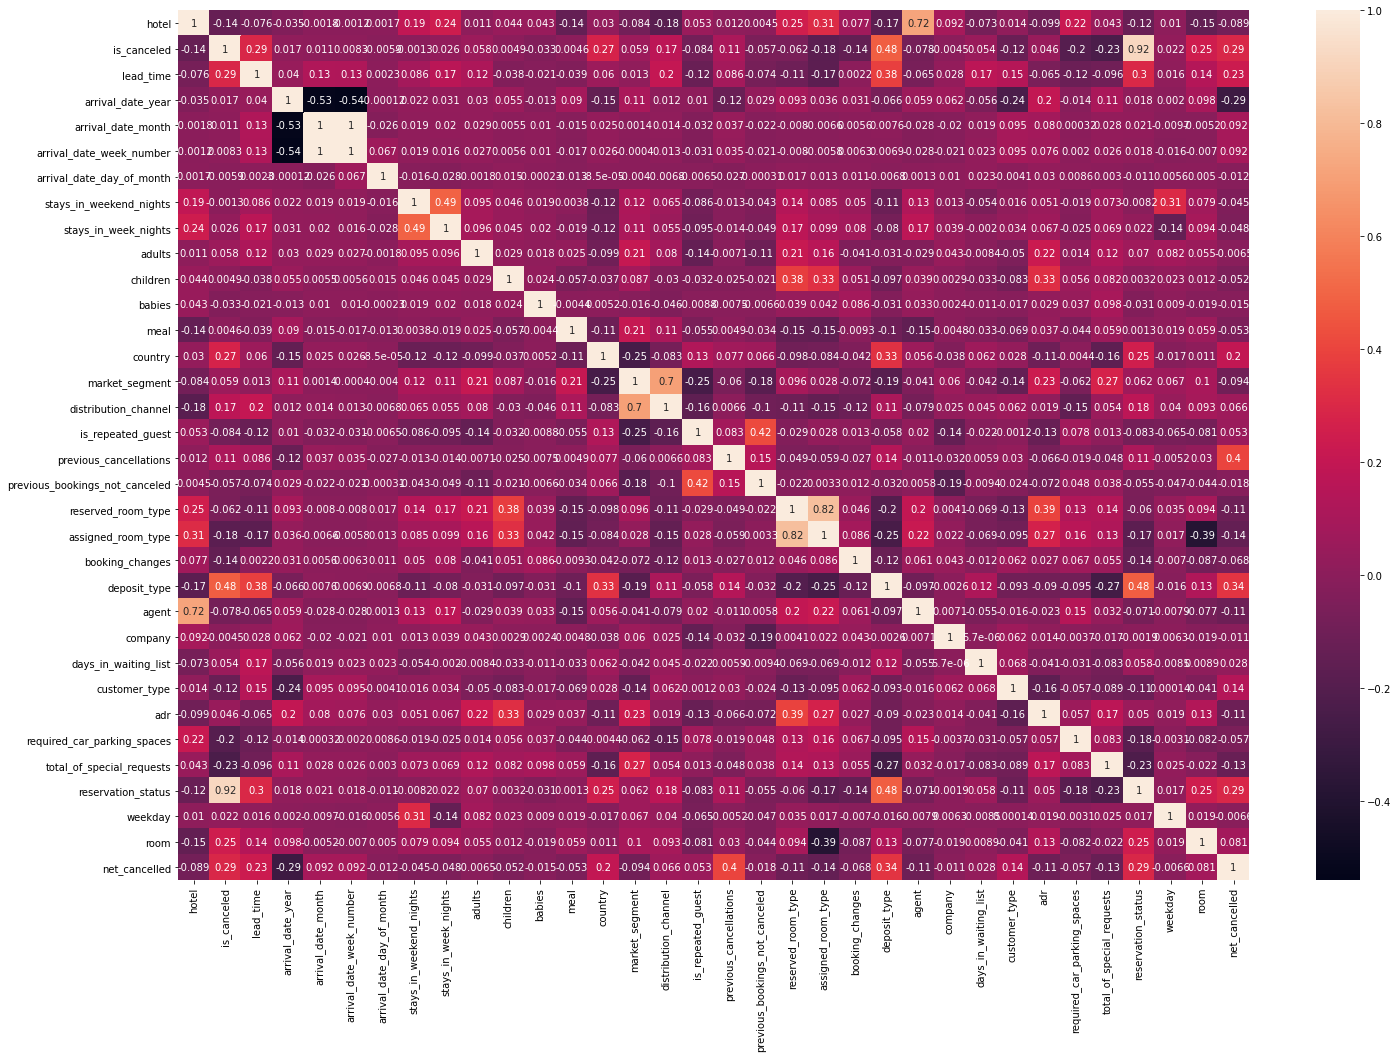

In [35]:
fig, ax = plt.subplots(figsize=(24, 16)) 
sns.heatmap(df.corr(), annot=True, ax = ax)

In [36]:
#Variance of the data
df.var()

hotel                                 0.223085
is_canceled                           0.233300
lead_time                         11422.361808
arrival_date_year                     0.500535
arrival_date_month                    9.546842
arrival_date_week_number            184.990111
arrival_date_day_of_month            77.107192
stays_in_weekend_nights               0.990258
stays_in_week_nights                  3.599010
adults                                0.330838
children                              0.159070
babies                                0.009508
meal                                  0.801927
country                            2023.411409
market_segment                        1.602172
distribution_channel                  0.458395
is_repeated_guest                     0.030507
previous_cancellations                0.713887
previous_bookings_not_canceled        2.244415
reserved_room_type                    2.874866
assigned_room_type                    3.476675
booking_chang

In [37]:
# Correlation depending on is_canceled

df.corr()['is_canceled'].abs().sort_values(ascending = False)

is_canceled                       1.000000
reservation_status                0.917176
deposit_type                      0.480483
net_cancelled                     0.292888
lead_time                         0.292876
country                           0.272496
room                              0.246768
total_of_special_requests         0.234877
required_car_parking_spaces       0.195701
assigned_room_type                0.175843
distribution_channel              0.171416
booking_changes                   0.144832
hotel                             0.137082
customer_type                     0.122024
previous_cancellations            0.110139
is_repeated_guest                 0.083745
agent                             0.078010
reserved_room_type                0.062216
market_segment                    0.059419
adults                            0.058182
previous_bookings_not_canceled    0.057365
days_in_waiting_list              0.054301
adr                               0.046492
babies     

In [38]:
X = df.drop(['is_canceled', 'reservation_status', 'reservation_status_date', 'date'], axis = 1)
y = df['is_canceled']
y = np.array(y)

In [57]:
# How many uncanceled (0) or canceled (1) records does the dataset contain?

print('Distribution is canceled (1) or not (0): \n' + str(pd.Series(y).value_counts()))
print('In Percent: \n' + str(pd.Series(y).value_counts() / pd.Series(y).count() * 100))

Distribution is canceled (1) or not (0): 
0    75011
1    44199
dtype: int64
In Percent: 
0    62.923412
1    37.076588
dtype: float64


In [ ]:
# The dataset is obviously very imbalanced. 
# A prediction with a high accuracy and Kappa is therefor only possible with a lot of try and error in feature optimization. 
# A possible solution: Oversampling!

In [58]:
# Oversampling: Balances the imbalanced dataset out by creating more samples with "canceled data" for better prediction results. 

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [59]:
# Scaling 

X_scaled = StandardScaler().fit_transform(X_resampled)

# Training

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size = 0.2, random_state = 0)

In [61]:
# After Oversampling

print('Distribution after Oversampling: \n' + str(pd.Series(y_resampled).value_counts()))

After Oversampling: 
1    75011
0    75011
dtype: int64


In [72]:
# Logistic Regression
model_lr = LogisticRegression().fit(X_train, y_train)
model_lr_prediction = model_lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, model_lr_prediction)

conf_lr = confusion_matrix(y_test, model_lr_prediction)
clf_report_lr = classification_report(y_test, model_lr_prediction)

print(f"Accuracy Score of Logistic Regression is : {accuracy_lr}")
print(f"Confusion Matrix : \n{conf_lr}")
print(f"Classification Report : \n{clf_report_lr}")

Accuracy Score of Logistic Regression is : 0.7764372604565906
Confusion Matrix : 
[[12060  2958]
 [ 3750 11237]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.76      0.80      0.78     15018
           1       0.79      0.75      0.77     14987

    accuracy                           0.78     30005
   macro avg       0.78      0.78      0.78     30005
weighted avg       0.78      0.78      0.78     30005

C:\Users\Diana Jaffé\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_resul

In [73]:
kappa_lr = cohen_kappa_score(y_test, model_lr_prediction)
kappa_lr

0.5528496552224229

In [62]:
# Random Forest
model_rf = RandomForestClassifier(n_estimators=600).fit(X_train, y_train)   # 600: 0.8995050750775941
model_rf_prediction = model_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, model_rf_prediction)

conf_rf = confusion_matrix(y_test, model_rf_prediction)
clf_report_rf = classification_report(y_test, model_rf_prediction)

print(f"Accuracy Score of Random Forest is : {accuracy_rf}")
print(f"Confusion Matrix : \n{conf_rf}")
print(f"Classification Report : \n{clf_report_rf}")

0.9320113314447592

In [63]:
kappa_rf = cohen_kappa_score(y_test, model_rf_prediction)   # 600: 0.7826201039672709
kappa_rf

0.8640262820588093

In [64]:
# Decision Tree
model_dt = tree.DecisionTreeClassifier().fit(X_train, y_train)
model_dt_prediction = model_dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, model_dt_prediction)

conf_dt = confusion_matrix(y_test, model_dt_prediction)
clf_report_dt = classification_report(y_test, model_dt_prediction)

print(f"Accuracy Score of Decision Tree is : {accuracy_dt}")
print(f"Confusion Matrix : \n{conf_dt}")
print(f"Classification Report : \n{clf_report_dt}")

Accuracy Score of Decision Tree is : 0.9054157640393268
Confusion Matrix : 
[[13204  1814]
 [ 1024 13963]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.93      0.88      0.90     15018
           1       0.89      0.93      0.91     14987

    accuracy                           0.91     30005
   macro avg       0.91      0.91      0.91     30005
weighted avg       0.91      0.91      0.91     30005



In [65]:
kappa_dt = cohen_kappa_score(y_test, model_dt_prediction)
kappa_dt

0.8108416171557763

Maximum:  0.9824120603015075
Mean:  0.8119778995734339


<AxesSubplot:>

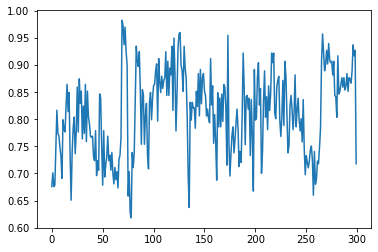

In [70]:
# K-Fold DecisionTree
model_kfdt = cross_val_score(tree.DecisionTreeClassifier(max_depth = 7), X, y, cv=300)
print('Maximum: ', model_kfdt.max())
print('Mean: ', model_kfdt.mean())

model_kfdt = pd.Series(model_kfdt)
model_kfdt.plot()


In [ ]:
# KNN
model_knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2).fit(X_train, y_train)
model_knn_prediction = model_knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, model_knn_prediction)

conf_knn = confusion_matrix(y_test, model_knn_prediction)
clf_report_knn = classification_report(y_test, model_knn_prediction)

print(f"Accuracy Score of Ada Boost Classifier is : {accuracy_knn}")
print(f"Confusion Matrix : \n{conf_knn}")
print(f"Classification Report : \n{clf_report_knn}")

In [ ]:
kappa_knn = cohen_kappa_score(y_test, model_knn_prediction)
kappa_knn

In [ ]:
# Ada Boost
model_ada = AdaBoostClassifier(n_estimators = 1000).fit(X_train, y_train)
model_ada_prediction = model_ada.predict(X_test)
accuracy_ada = accuracy_score(y_test, model_ada_prediction)

conf_ada = confusion_matrix(y_test, model_ada_prediction)
clf_report_ada = classification_report(y_test, model_ada_prediction)

print(f"Accuracy Score of Ada Boost Classifier is : {accuracy_ada}")
print(f"Confusion Matrix : \n{conf_ada}")
print(f"Classification Report : \n{clf_report_ada}")

In [ ]:
kappa_ada = cohen_kappa_score(y_test, model_ada_prediction)
kappa_ada

In [ ]:
# Gradient Boosting Classifier
model_gb = GradientBoostingClassifier().fit(X_train, y_train)
model_gb_prediction = model_gb.predict(X_test)

accuracy_gb = accuracy_score(y_test, model_gb_prediction)
conf_gb = confusion_matrix(y_test, model_gb_prediction)
clf_report_gb = classification_report(y_test, model_gb_prediction)

print(f"Accuracy Score of Ada Boost Classifier is : {accuracy_gb}")
print(f"Confusion Matrix : \n{conf_gb}")
print(f"Classification Report : \n{clf_report_gb}")

In [ ]:
kappa_gb = cohen_kappa_score(y_test, model_gb_prediction)
kappa_gb

In [ ]:
# XgBoost Classifier
model_xgb = XGBClassifier(booster = 'gbtree', learning_rate = 0.1, max_depth = 5, n_estimators = 180).fit(X_train, y_train)
model_xgb_prediction = model_xgb.predict(X_test)

accuracy_xgb = accuracy_score(y_test, model_xgb_prediction)
conf_xgb = confusion_matrix(y_test, model_xgb_prediction)
clf_report_xgb = classification_report(y_test, model_xgb_prediction)

print(f"Accuracy Score of XgBoost Classifier is : {accuracy_xgb}")
print(f"Confusion Matrix : \n{conf_xgb}")
print(f"Classification Report : \n{clf_report_xgb}")

In [ ]:
kappa_xgb = cohen_kappa_score(y_test, model_xgb_prediction)
kappa_xgb

In [ ]:
# Cat Boost Classifier
model_cat = CatBoostClassifier(iterations=100).fit(X_train, y_train)
model_cat_prediction = model_cat.predict(X_test)

accuracy_cat = accuracy_score(y_test, model_cat_prediction)
conf_cat = confusion_matrix(y_test, model_cat_prediction)
clf_report_cat = classification_report(y_test, model_cat_prediction)

print(f"Accuracy Score of Cat Boost Classifier is : {accuracy_cat}")
print(f"Confusion Matrix : \n{conf_cat}")
print(f"Classification Report : \n{clf_report_cat}")

In [ ]:
kappa_cat = cohen_kappa_score(y_test, model_cat_prediction)
kappa_cat

In [ ]:
# Extra Trees Classifier
model_etc = ExtraTreesClassifier().fit(X_train, y_train)
model_etc_prediction = model_etc.predict(X_test)

accuracy_etc = accuracy_score(y_test, model_etc_prediction)
conf_etc = confusion_matrix(y_test, model_etc_prediction)
clf_report_etc = classification_report(y_test, model_etc_prediction)

print(f"Accuracy Score of Cat Boost Classifier is : {accuracy_etc}")
print(f"Confusion Matrix : \n{conf_etc}")
print(f"Classification Report : \n{clf_report_etc}")

In [ ]:
kappa_etc = cohen_kappa_score(y_test, model_etc_prediction)
kappa_etc

In [ ]:
# LGBM Classifier
model_lgbm = LGBMClassifier(learning_rate = 1).fit(X_train, y_train)
model_lgbm_prediction = model_lgbm.predict(X_test)

accuracy_lgbm = accuracy_score(y_test, model_lgbm_prediction)
conf_lgbm = confusion_matrix(y_test, model_lgbm_prediction)
clf_report_lgbm = classification_report(y_test, model_lgbm_prediction)

print(f"Accuracy Score of Cat Boost Classifier is : {accuracy_lgbm}")
print(f"Confusion Matrix : \n{conf_lgbm}")
print(f"Classification Report : \n{clf_report_lgbm}")

In [ ]:
kappa_lgbm = cohen_kappa_score(y_test, model_lgbm_prediction)
kappa_lgbm

In [ ]:
# Voting Classifier
classifiers = [('Gradient Boosting Classifier', model_gb), ('Cat Boost Classifier', model_cat), ('XGboost', model_xgb),  
               ('Decision Tree', model_dt), ('Extra Tree', model_etc), ('Light Gradient', model_lgbm), ('Random Forest', model_rf), 
               ('Ada Boost', model_ada), ('Logistic', model_lr), ('Knn', model_knn)]
model_vc = VotingClassifier(estimators = classifiers).fit(X_train, y_train)
model_vc_prediction = model_vc.predict(X_test)

accuracy_vc = accuracy_score(y_test, model_vc_prediction)
conf_vc = confusion_matrix(y_test, model_vc_prediction)
clf_report_vc = classification_report(y_test, model_vc_prediction)

print(f"Accuracy Score of Voting Classifier is : {accuracy_vc}")
print(f"Confusion Matrix : \n{conf_vc}")
print(f"Classification Report : \n{clf_report_vc}")

In [ ]:
kappa_vc = cohen_kappa_score(y_test, model_vc_prediction)
kappa_vc

In [ ]:
# Models Comparison
models = pd.DataFrame({
    'Model' : ['Logistic Regression', 'KNN', 'Decision Tree Classifier', 'Random Forest Classifier','Ada Boost Classifier',
             'Gradient Boosting Classifier', 'XgBoost', 'Cat Boost', 'Extra Trees Classifier', 'LGBM', 'Voting Classifier', 'K-Fold Decision Tree'],
    'Score' : [accuracy_lr, accuracy_knn, accuracy_dt, accuracy_rf, accuracy_ada, accuracy_gb, accuracy_xgb, accuracy_cat, 
              accuracy_etc, accuracy_lgbm, accuracy_vc, model_kfdt.mean()],
    'Kappa' : [kappa_lr, kappa_knn, kappa_dt, kappa_rf, kappa_ada, kappa_gb, kappa_xgb, kappa_cat, kappa_etc, kappa_lgbm, 
              kappa_vc, model_kfdt.mean()]
})


models.sort_values(by = 'Kappa', ascending = False)